Goal:
classify a task for a given student as (1) too easy, (2) just right, or (3) too difficult.

Data:
- Robotanist, order and times of solved tasks
- proxy for difficulty levels:
- too easy = less than 1 minute
- too difficult = more than 10 minutes

Ideally, the same methods should be usable in scenario where we have explicit user information (qualitative data) about perceived difficulty (obtained via the flow-level question).

Usage:
- soft recommendation via color each task (too easy, just right, too difficult)
- soft recommendation via coarse time predictions (1m, 10m, >20m)
- set challenge level (1m or 10m)
- hard recommendation: hide/lock too easy/difficult tasks

In [85]:
%matplotlib inline
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# Data

In [3]:
ordering = pd.read_csv('../data/robotanik/user_time_ordering.csv', index_col='Login')
# Make task IDs integers (from string labels).
ordering.columns = map(int, ordering.columns)
ordering.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
Login,,,,,,,,,,,,,,,,,,,,,
U1,1.0,2.0,13.0,5.0,NaN,9.0,NaN,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U2,1.0,2.0,4.0,3.0,5.0,6.0,9.0,10.0,8.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,58.0,59.0,60.0,61.0
U4,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U5,1.0,2.0,3.0,4.0,16.0,5.0,15.0,NaN,11.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U6,1.0,2.0,3.0,7.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
times = pd.read_csv('../data/robotanik/user_time.csv', index_col='Login')
# Make task IDs integers (from string labels).
times.columns = map(int, times.columns)
# Infere "true labels" (too difficult case)
TOO_DIFFICULT_THRESHOLD_MINUTES = 10
labels = times > 60 * TOO_DIFFICULT_THRESHOLD_MINUTES
#labels.head()
# We will work with log times; TODO: explain why
times = times.applymap(np.log)
times.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
Login,,,,,,,,,,,,,,,,,,,,,
U1,3.218876,2.564949,2.639057,3.637586,NaN,6.129050,NaN,NaN,NaN,4.882802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U2,2.302585,1.609438,3.891820,2.944439,4.521789,3.135494,4.043051,3.688879,3.737670,5.351858,...,NaN,NaN,NaN,NaN,NaN,NaN,5.220356,4.727388,3.583519,4.290459
U4,3.258097,1.791759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U5,3.951244,3.663562,3.218876,2.944439,5.897154,3.218876,4.595120,NaN,4.025352,3.828641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U6,4.219508,2.995732,3.465736,2.890372,NaN,3.737670,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


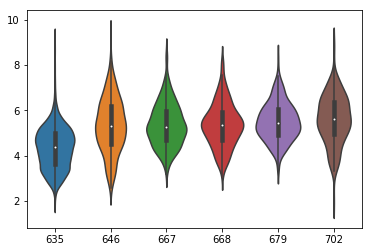

In [67]:
# distribution of log-times
sns.violinplot(data=times[[635, 646, 667, 668, 679, 702]])

The dataset contains about 10K of users and 80 tasks.

In [68]:
times.shape

(10605, 78)

# Features

Start with 2 features:
1. how many tasks has the student already solved (student_solved_percentage)
2. how many students have solved the task (task_solved_percentage)

Feature ideas:
- student-related (skill):
    - number of solved tasks
    - number of solved tasks in easy/flow/difficult mode
    - the most difficult solved task [in easy/flow/difficult mode]
    - which tasks solved [in which mode] / log-times / quartiles
- task-related (difficulty)
    - how many students have solved the task (percentage)
    - mean/median order
    - median log-time
    - percentage of easy/flow/difficult attempts
- content based

,task_solved_percentage,task_time_median
635,1.0,3.329647
636,1.0,2.381087
637,0.8,3.310037
638,0.8,3.138322
639,0.6,4.516324


In [124]:
# create a dataframe of events (student-task interactions)
task_count = times.shape[1]
data = []
for user_id in ordering.index:
    order = ordering.loc[user_id].dropna().sort_values()
    for task_id, student_order in order.items():
        event = OrderedDict(
            student_id=int(user_id[2:]),
            student_order=int(student_order),
            student_solved_percentage=(student_order-1)/task_count,
            task_id=int(task_id),
            time=times.loc[user_id, task_id],
            label=labels.loc[user_id, task_id])
        data.append(event)


events = pd.DataFrame(data)
print(events.shape)
events.head()

(121258, 6)


,student_id,student_order,student_solved_percentage,task_id,time,label
0,1,1,0.000000,635,3.218876,False
1,1,2,0.012821,636,2.564949,False
2,1,3,0.025641,656,4.595120,False
3,1,4,0.038462,698,3.850148,False
4,1,5,0.051282,638,3.637586,False


In [125]:
# train-test split (todo: cross validation)
# user-stratified
events_train = events[events.student_id < 15000]
events_test = events[events.student_id >= 15000]
print(len(events_train), len(events_test))

82219 39039


In [126]:
# compute task features on training-set
def compute_task_features(events_train):
    tasks = events_train.groupby('task_id')
    n_students = events_train.student_id.nunique()
    task_features = pd.DataFrame({
      'task_time_median': tasks.time.median(),
      'task_solved_percentage': tasks.time.count() / n_students
    })
    return task_features

task_featues = compute_task_features(events_train)
task_features.head()

,task_solved_percentage,task_time_median
task_id,,
635,0.881162,4.369448
636,0.839055,3.044522
637,0.602259,4.290459
638,0.687940,4.276666
639,0.128961,5.056246


In [127]:
# join events with task features
def join_task_features(events):
    events = pd.merge(events, task_features, left_on='task_id', right_index=True)
    events.sort_values(by=['student_id', 'student_order'], inplace=True)
    return events

events_train = join_task_features(events_train)
events_test = join_task_features(events_test)

events_train.head()

,student_id,student_order,student_solved_percentage,task_id,time,label,task_solved_percentage,task_time_median
0,1,1,0.000000,635,3.218876,False,0.881162,4.369448
1,1,2,0.012821,636,2.564949,False,0.839055,3.044522
2,1,3,0.025641,656,4.595120,False,0.476819,4.442651
3,1,4,0.038462,698,3.850148,False,0.470217,4.406719
4,1,5,0.051282,638,3.637586,False,0.687940,4.276666


In [135]:
positives.sample(3)

,student_id,student_order,student_solved_percentage,task_id,time,label,task_solved_percentage,task_time_median
6841,452,8,0.089744,645,6.421622,True,0.197477,4.990433
18591,2290,36,0.448718,697,6.645091,True,0.036385,5.503278
42467,6529,46,0.576923,668,6.720220,True,0.043134,5.320565


Text(0.4,-0.1,'difficult')

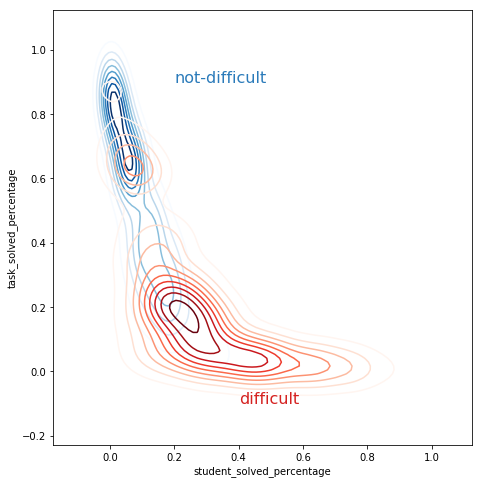

In [140]:
positives = events_train.query("label == True").sample(500)
negatives = events_train.query("label == False").sample(500)

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(
    negatives.student_solved_percentage,
    negatives.task_solved_percentage,
    cmap="Blues", shade=False, shade_lowest=False)
ax = sns.kdeplot(
    positives.student_solved_percentage,
    positives.task_solved_percentage,
    cmap="Reds", shade=False, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(0.2, 0.9, "not-difficult", size=16, color=blue)
ax.text(0.4, -0.1, "difficult", size=16, color=red)

In [ ]:
# TODO: try simple models (logistic regression with 0-2 features)

In [141]:
model = LogisticRegression()
X = events_train[['student_solved_percentage', 'task_solved_percentage']]
y = events_train.label
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [144]:
# TODO: evaluation - how well the models perform on the test set?
# TODO: create test

# mean accuracy in this case
X_test = events_test[['student_solved_percentage', 'task_solved_percentage']]
y_test = events_test.label
print('train set accuracy:', model.score(X, y))
print('test set accuracy:', model.score(X_test, y_test))

train set accuracy: 0.947834442161
test set accuracy: 0.957708957709
